In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/MNIST", one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [3]:
units_1 = 256
units_2 = 128
img_size = 28*28

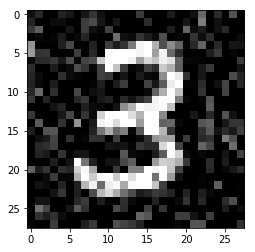

In [4]:
noisy = mnist.train.images + np.random.normal(loc=0.0, scale=0.2,size=784)
train_noisy = np.clip(noisy, 0., 1.)
plt.imshow(train_noisy[11].reshape(28,28),cmap='binary_r')

In [5]:
x_noisy = tf.placeholder(tf.float32,shape=[None,784])
x_real = tf.placeholder(tf.float32,shape=[None,784])

In [6]:
## NN autoencoder
enc_layer1 = tf.layers.dense(inputs=x_train,name='encoder_1',units=units_1,activation=tf.nn.relu)
enc_layer2 = tf.layers.dense(inputs=enc_layer1,name='encoder_2',units=units_2,activation=tf.nn.relu)
dec_layer1 = tf.layers.dense(inputs=enc_layer2,name='decoder_1',units=units_1,activation=tf.nn.relu)
dec_layer2 = tf.layers.dense(inputs=dec_layer1,name='decoder_2',units=img_size,activation=None)

In [6]:
## Deep denoising autoencoder
x_real_image = tf.reshape(x_real,shape=[-1,28,28,1])
x_noise_image = tf.reshape(x_noisy,shape=[-1,28,28,1])
conv1 = tf.layers.conv2d(inputs=x_noise_image,filters=16,kernel_size=(5,5),strides=(1,1),padding='SAME',activation=tf.nn.relu,name='conv1')
maxpool1 = tf.layers.max_pooling2d(inputs=conv1,pool_size=(2,2),strides=(2,2),name='pool1')
conv2 = tf.layers.conv2d(inputs=maxpool1,filters=16,kernel_size=(5,5),strides=(1,1),padding='SAME',activation=tf.nn.relu,name='conv2')
maxpool2 = tf.layers.max_pooling2d(inputs=conv2,pool_size=(2,2),strides=(2,2),name='pool2')
conv3 = tf.layers.conv2d(inputs=maxpool2,filters=16,kernel_size=(5,5),strides=(1,1),padding='SAME',activation=tf.nn.relu,use_bias=True,name='conv3')
upsample1 = tf.layers.conv2d_transpose(inputs=conv3,filters=16,kernel_size=(5,5),strides=(2,2),padding='SAME',name='upsample1')
upsample2 = tf.layers.conv2d_transpose(inputs=upsample1,filters=16,kernel_size=5,strides=2,padding='SAME',name='upsample2')
dec_layer = tf.layers.conv2d(inputs=upsample2,filters=1,kernel_size=5,strides=1,padding='SAME',name='logits',use_bias=True)

In [7]:
for var in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES):
    print var

<tf.Variable 'conv1/kernel:0' shape=(5, 5, 1, 16) dtype=float32_ref>
<tf.Variable 'conv1/bias:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'conv2/kernel:0' shape=(5, 5, 16, 16) dtype=float32_ref>
<tf.Variable 'conv2/bias:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'conv3/kernel:0' shape=(5, 5, 16, 16) dtype=float32_ref>
<tf.Variable 'conv3/bias:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'upsample1/kernel:0' shape=(5, 5, 16, 16) dtype=float32_ref>
<tf.Variable 'upsample1/bias:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'upsample2/kernel:0' shape=(5, 5, 16, 16) dtype=float32_ref>
<tf.Variable 'upsample2/bias:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'logits/kernel:0' shape=(5, 5, 16, 1) dtype=float32_ref>
<tf.Variable 'logits/bias:0' shape=(1,) dtype=float32_ref>


In [8]:
decoded = tf.sigmoid(dec_layer,name='decoded')


In [9]:
x_pred = decoded
cost = tf.reduce_mean(tf.pow((x_real_image-x_pred),2))
optimizer = tf.train.RMSPropOptimizer(0.01).minimize(cost)

In [10]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [11]:
def gen_batch(batch_size):
    idx = np.random.choice(train_noisy.shape[0],batch_size,replace=True)
    return train_noisy[idx],mnist.train.images[idx]

In [12]:
iterations = 2000
batch_size = 16
for i in range(iterations):
    
    x_noisy_batch,x_real_batch = gen_batch(batch_size)
    feed_dict_train = {x_noisy:x_noisy_batch,x_real:x_real_batch}
    _,cst = sess.run([optimizer,cost],feed_dict=feed_dict_train)
    if i%100==0:
        print "iterations: {0},cost: {1}".format(i,cst)

iterations: 0,cost: 0.23267416656
iterations: 100,cost: 0.106294132769
iterations: 200,cost: 0.0673366710544
iterations: 300,cost: 0.0211136285216
iterations: 400,cost: 0.024483460933
iterations: 500,cost: 0.0173194743693
iterations: 600,cost: 0.0158863160759
iterations: 700,cost: 0.0143023133278
iterations: 800,cost: 0.0188645645976
iterations: 900,cost: 0.0136170554906
iterations: 1000,cost: 0.0119380857795
iterations: 1100,cost: 0.0120822777972
iterations: 1200,cost: 0.0101149752736
iterations: 1300,cost: 0.0135801360011
iterations: 1400,cost: 0.0131791997701
iterations: 1500,cost: 0.0123865455389
iterations: 1600,cost: 0.00927766319364
iterations: 1700,cost: 0.0115372389555
iterations: 1800,cost: 0.0106222620234
iterations: 1900,cost: 0.0143605312333


(4, 28, 28, 1)


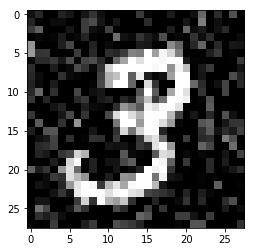

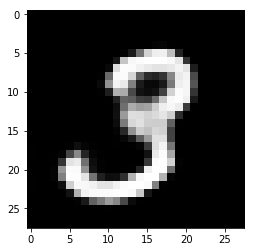

In [14]:
rec_img = sess.run(x_pred,feed_dict={x_noisy:train_noisy[:4],x_real:mnist.train.images[:4]})
plt.figure(1)
plt.imshow(train_noisy[1].reshape(28,28),cmap='binary_r')
plt.figure(2)
plt.imshow(rec_img[1,:,:,0],cmap = 'binary_r')
print rec_img.shape

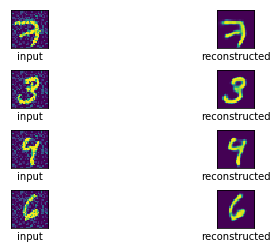

In [15]:
fig,axes = plt.subplots(4,2)
fig.subplots_adjust(hspace=0.6,wspace=0.6)
n = 0
for i,ax in enumerate(axes.flat):
    
    if i%2==0:
        ax.set_xlabel("input")
        ax.imshow(train_noisy[n].reshape(28,28))
    else:
        ax.set_xlabel("reconstructed")
        ax.imshow(rec_img[n,:,:,0])
        n+=1
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()
